## simple 1d bayesian optimization - unfinished

Some resources that helped me:

http://krasserm.github.io/2018/03/19/gaussian-processes/ (gaussian processes)

https://distill.pub/2019/visual-exploration-gaussian-processes/ (gaussian processes)

https://juanitorduz.github.io/multivariate_normal/ (sampling multivariate normal)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def f(X, noise=NOISE):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

In [39]:
NOISE = 0.2

Text(0.5, 1.0, 'observed func and noisy values')

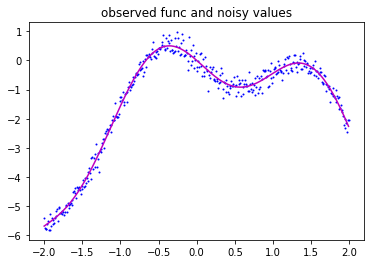

In [41]:
X = np.arange(-2.0,2.0,step=.01)
Y = f(X)
Y_noiseless = f(X,noise=0.0)
plt.scatter(X,Y,color='b',s=1)
plt.plot(X,Y_noiseless,color='m')
plt.title('observed func and noisy values')

In [100]:
def rbf(x1,x2,l=10.0,var=1.0):
    #inputs x1,x2 - floats
    #outputs rbf score
    diff = x1-x2
    return (var**2)*np.exp((-0.5*(x1**2+x2**2-(2*x1*x2)))/(l**2))

class GaussianProcess:
    def __init__(self,ker_func=rbf):
        self.cov_matrix = []
        self.observed_points = []
        self.kernel = ker_func
    
    def add_observations(self,points):
        #points - list of [x,y] observations
        
        for point in points:
            self.cov_matrix.append([])
            for i in range(len(self.observed_points)):
                k = self.kernel(point[0],self.observed_points[i][0])
                self.cov_matrix[-1].append(k)
                self.cov_matrix[i].append(k)
            self.cov_matrix[-1].append(self.kernel(point[0],point[0]))
            self.observed_points.append(point)
    
    def sample_points(self,points):
        #sample values of f at points
        #points - list of x-values to sample
        k_star = np.empty((len(self.observed_points),len(points)))
        for obs_ind in range(len(self.observed_points)):
            for new_ind in range(len(points)):
                k_star[obs_ind][new_ind] = self.kernel(self.observed_points[obs_ind][0],points[new_ind])
        
        k_star_star = np.empty((len(points),len(points)))
        for i in range(len(points)):
            for j in range(len(points)):
                k = self.kernel(points[i],points[j])
                k_star_star[i][j] = k
                k_star_star[j][i] = k
        
        k_inv = np.linalg.inv(np.array(self.cov_matrix))+(NOISE*np.eye(len(self.observed_points)))
        k_star_t = np.transpose(k_star)
        
        mu_star = np.matmul(k_star_t,k_inv)
        mu_star = np.matmul(mu_star,np.array([[point[1]] for point in self.observed_points])).reshape((len(points)))
        
        cov_star = np.matmul(k_star_t,k_inv)
        cov_star = k_star_star - np.matmul(cov_star,k_star)+(NOISE*np.eye(len(points)))
        
        return np.random.multivariate_normal(mu_star,cov_star)
        
        # below has errors bc cov_star isn't positive semidefinite. im guessing very small negative floats on the eigenvalues.
#         L = np.linalg.cholesky(cov_star)
#         u = np.random.normal(loc=0,scale=1,size=(len(self.points),1))
#         x = np.dot(L,u)
#         return x

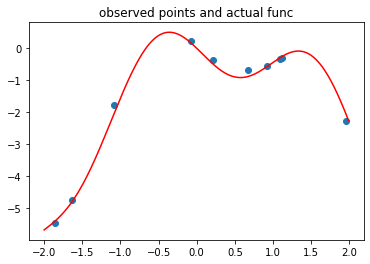

In [111]:
gp = GaussianProcess()
initial_obs = np.sort(np.random.uniform(-2.0,2.0,size=(10,)))
initial_obs = np.array([[obs,f(obs)] for obs in initial_obs])
plt.scatter(initial_obs[:,0],initial_obs[:,1])
plt.plot(X,Y_noiseless,color='r')
plt.title('observed points and actual func')
plt.show()
gp.add_observations(initial_obs)

C:\Users\Louis\AppData\Local\Temp\ipykernel_29216\531089418.py:49: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu_star,cov_star)
C:\Users\Louis\AppData\Local\Temp\ipykernel_29216\531089418.py:49: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu_star,cov_star)
C:\Users\Louis\AppData\Local\Temp\ipykernel_29216\531089418.py:49: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu_star,cov_star)
C:\Users\Louis\AppData\Local\Temp\ipykernel_29216\531089418.py:49: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu_star,cov_star)
C:\Users\Louis\AppData\Local\Temp\ipykernel_29216\531089418.py:49: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu_star,cov_star)
C:\Users\Louis\AppData\Local\Temp\ipykernel_29216\531089418.py:49: RuntimeWarning: covariance i

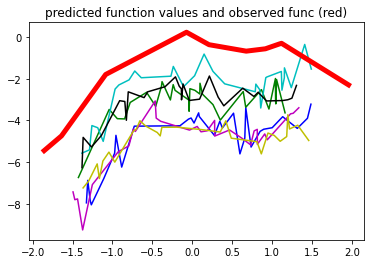

In [112]:
colors = ['b','g','c','m','y','k']
for test in range(6):
    test_x1 = np.random.uniform(-1.5,1.5,size=(30,))
    test_y1 = gp.sample_points(test_x1)
    reorder = np.argsort(test_x1)
    test_x1 = test_x1[reorder]
    test_y1 = test_y1[reorder]
    plt.plot(test_x1,test_y1,color=colors[test])
plt.plot(initial_obs[:,0],initial_obs[:,1],color='r',lw=5)
plt.title('predicted function values and observed func (red)')
plt.show()